## Семинар 7: "Методы оптимизации"

ФИО: Фролов Михаил Алексеевич

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys
%matplotlib inline

/home/mi.frolov/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [2]:
#Class GD
class GD(object):
    def __init__(self, f, df, init=(1,1), max_iter=100):
        self.f = f
        self.df = df
        self.theta = np.array(init, dtype='float32')
        self.max_iter = max_iter
        self.step_n = 0
        
    def update(self, lr):
        self.step_n += 1
        self.theta -= lr * self.df(self.theta)
        

In [3]:
#Class Momentum
class Momentum(object):
    def __init__(self, f, df, init=(1,1), max_iter=100, gamma=0.9):
        self.f = f
        self.df = df
        self.theta = np.array(init, dtype='float32')
        self.max_iter = max_iter
        self.step_n = 0
        self.gamma = gamma
        self.v = 0
        
    def update(self, lr):
        self.step_n += 1
        self.v = self.v * self.gamma + lr * self.df(self.theta)
        self.theta -= self.v

In [4]:
#Class NAG
class NAG(object):
    def __init__(self, f, df, init=(1,1), max_iter=100, gamma=0.9):
        self.f = f
        self.df = df
        self.theta = np.array(init, dtype='float32')
        self.max_iter = max_iter
        self.step_n = 0
        self.gamma = gamma
        self.v = 0
        
    def update(self, lr):
        self.step_n += 1
        self.v = self.v * self.gamma + lr * self.df(self.theta - self.v * self.gamma)
        self.theta -= self.v

In [5]:
#Class Adagrad
class Adagrad(object):
    def __init__(self, f, df, init=(1,1), max_iter=100, eps=1e-8):
        self.f = f
        self.df = df
        self.theta = np.array(init, dtype='float32')
        self.max_iter = max_iter
        self.step_n = 0
        self.eps = eps
        self.G = np.zeros_like(self.theta)
        
    def update(self, lr):
        self.step_n += 1
        g = self.df(self.theta)
        self.G += g ** 2
        self.theta -= lr / np.sqrt(self.G + self.eps) * g

In [6]:
#Class Adadelta
class Adadelta(object):
    def __init__(self, f, df, init=(1,1), max_iter=100, gamma=0.01, eps=1e-8):
        self.f = f
        self.df = df
        self.theta = np.array(init, dtype='float32')
        self.max_iter = max_iter
        self.step_n = 0
        self.gamma = gamma
        self.eps = eps
        self.EG = np.zeros_like(self.theta)
        self.EDelta = np.zeros_like(self.theta)
        
    def update(self, lr):
        self.step_n += 1
        g = self.df(self.theta)
        self.EG = self.gamma * self.EG + (1 - self.gamma) * g ** 2
        dtheta = lr * np.sqrt((self.EDelta + self.eps) / (self.EG + self.eps)) * g
        self.EDelta = self.gamma * self.EDelta + (1 - self.gamma) * dtheta ** 2
        self.theta -= dtheta

In [7]:
#Class Adam
class Adam(object):
    def __init__(self, f, df, init=(1,1), max_iter=100, beta1=0.9, beta2=0.999, eps=1e-8):
        self.f = f
        self.df = df
        self.theta = np.array(init, dtype='float32')
        self.max_iter = max_iter
        self.step_n = 0
        self.b1 = beta1
        self.b2 = beta2
        self.eps = eps
        self.m = np.zeros_like(self.theta)
        self.v = np.zeros_like(self.theta)
        
    def update(self, lr):
        self.step_n += 1
        g = self.df(self.theta)
        self.m = self.b1 * self.m + (1 - self.b1) * g
        self.v = self.b2 * self.v + (1 - self.b2) * g ** 2
        m_cap = self.m / (1 - self.b1 ** self.step_n)
        v_cap = self.v / (1 - self.b2 ** self.step_n)
        self.theta -= lr * m_cap / (np.sqrt(v_cap) + self.eps)

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [8]:
f = lambda X: X[0]**2+X[1]**2
df = lambda X: np.array([2*X[0], 2*X[1]])

In [9]:
def lines_plot(f, xb=-2, xt=2, yb=-2, yt=2, delta=0.05):
    x = np.arange(xb, xt, delta)
    y = np.arange(yb, yt, delta)
    X, Y = np.meshgrid(x, y)
    Z = np.array([f(x) for x in np.c_[X.reshape(-1,1), Y.reshape(-1,1)]]).reshape(X.shape[0], X.shape[1])
    result = plt.contour(X, Y, Z)
    plt.clabel(result, inline=1, fontsize=8)

# GD

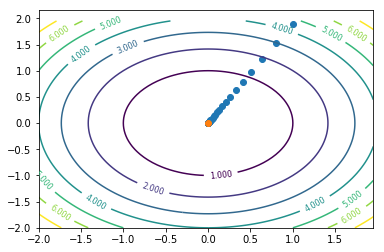

In [14]:
lines_plot(f, xb=-2, xt = 2, yb = -2, yt = 2, delta = 0.05)
path = np.zeros((2,1000))
opt = GD(f,df, init=(1,1.9))
for i in range(path.shape[1]):
    path[0, i], path[1,i] = opt.theta
    opt.update(1e-1)
plt.scatter(path[0], path[1])
plt.scatter(path[0, -1:], path[1, -1:])


# Momentum

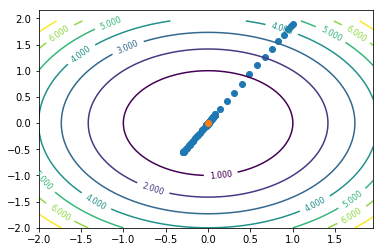

In [15]:
lines_plot(f, xb=-2, xt = 2, yb = -2, yt = 2, delta = 0.05)
path = np.zeros((2,1000))
opt = Momentum(f,df, init=(1,1.9))
for i in range(path.shape[1]):
    path[0, i], path[1,i] = opt.theta
    opt.update(1e-2)
plt.scatter(path[0], path[1])
plt.scatter(path[0, -1:], path[1, -1:])


# Adagrad

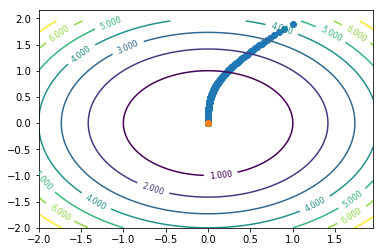

In [16]:
lines_plot(f, xb=-2, xt = 2, yb = -2, yt = 2, delta = 0.05)
path = np.zeros((2,1000))
opt = Adagrad(f,df, init=(1,1.9))
for i in range(path.shape[1]):
    path[0, i], path[1,i] = opt.theta
    opt.update(1e-1)
plt.scatter(path[0], path[1])
plt.scatter(path[0, -1:], path[1, -1:])


# Adadelta

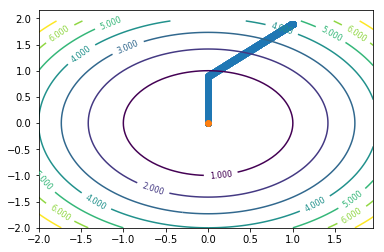

In [17]:
lines_plot(f, xb=-2, xt = 2, yb = -2, yt = 2, delta = 0.05)
path = np.zeros((2,1000))
opt = Adadelta(f,df, init=(1,1.9))
for i in range(path.shape[1]):
    path[0, i], path[1,i] = opt.theta
    opt.update(1e0)
plt.scatter(path[0], path[1])
plt.scatter(path[0, -1:], path[1, -1:])


# Adam

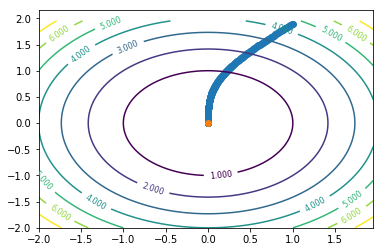

In [19]:
lines_plot(f, xb=-2, xt = 2, yb = -2, yt = 2, delta = 0.05)
path = np.zeros((2,1000))
opt = Adam(f,df, init=(1,1.9))
for i in range(path.shape[1]):
    path[0, i], path[1,i] = opt.theta
    opt.update(1e-2)
plt.scatter(path[0], path[1])
plt.scatter(path[0, -1:], path[1, -1:])


<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [20]:
f = lambda X: np.sin(X[0])*X[0]**2+np.sin(X[1])*X[1]**2
df = lambda X: np.array([2*X[0]*np.sin(X[0]) + np.cos(X[0])*X[0]**2, 2*X[1]*np.sin(X[1]) + np.cos(X[1])*X[1]**2])

# GD

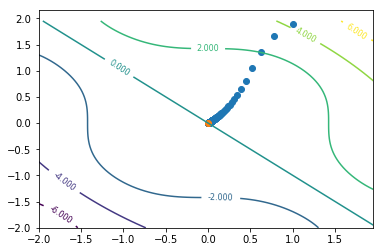

In [21]:
lines_plot(f, xb=-2, xt = 2, yb = -2, yt = 2, delta = 0.05)
path = np.zeros((2,1000))
opt = GD(f,df, init=(1,1.9))
for i in range(path.shape[1]):
    path[0, i], path[1,i] = opt.theta
    opt.update(1e-1)
plt.scatter(path[0], path[1])
plt.scatter(path[0, -1:], path[1, -1:])


# Momentum

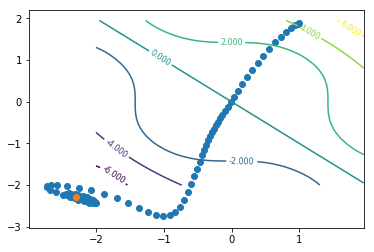

In [22]:
lines_plot(f, xb=-2, xt = 2, yb = -2, yt = 2, delta = 0.05)
path = np.zeros((2,1000))
opt = Momentum(f,df, init=(1,1.9))
for i in range(path.shape[1]):
    path[0, i], path[1,i] = opt.theta
    opt.update(1e-2)
plt.scatter(path[0], path[1])
plt.scatter(path[0, -1:], path[1, -1:])


# Adagrad

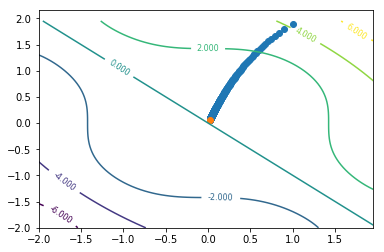

In [23]:
lines_plot(f, xb=-2, xt = 2, yb = -2, yt = 2, delta = 0.05)
path = np.zeros((2,1000))
opt = Adagrad(f,df, init=(1,1.9))
for i in range(path.shape[1]):
    path[0, i], path[1,i] = opt.theta
    opt.update(1e-1)
plt.scatter(path[0], path[1])
plt.scatter(path[0, -1:], path[1, -1:])


# Adadelta

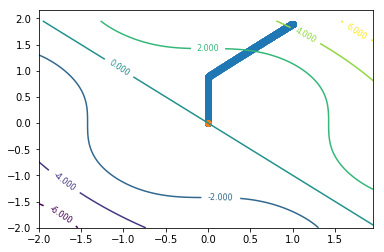

In [24]:
lines_plot(f, xb=-2, xt = 2, yb = -2, yt = 2, delta = 0.05)
path = np.zeros((2,1000))
opt = Adadelta(f,df, init=(1,1.9))
for i in range(path.shape[1]):
    path[0, i], path[1,i] = opt.theta
    opt.update(1e0)
plt.scatter(path[0], path[1])
plt.scatter(path[0, -1:], path[1, -1:])


# Adam

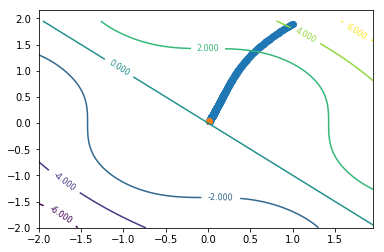

In [25]:
lines_plot(f, xb=-2, xt = 2, yb = -2, yt = 2, delta = 0.05)
path = np.zeros((2,1000))
opt = Adam(f,df, init=(1,1.9))
for i in range(path.shape[1]):
    path[0, i], path[1,i] = opt.theta
    opt.update(1e-2)
plt.scatter(path[0], path[1])
plt.scatter(path[0, -1:], path[1, -1:])


<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [29]:
f = lambda X: np.sin(X[0]**2)*X[0]**2+np.sin(X[1]**2)*X[1]**2
df = lambda X: np.array([2*X[0]*np.sin(X[0]**2) + 2*np.cos(X[0]**2)*X[0]**3,2*X[1]*np.sin(X[1]**2) + 2*np.cos(X[1]**2)*X[1]**3])

# GD

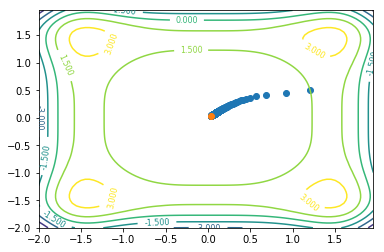

In [33]:
lines_plot(f, xb=-2, xt = 2, yb = -2, yt = 2, delta = 0.05)
path = np.zeros((2,1000))
opt = GD(f,df, init=(1.2, 0.5))
for i in range(path.shape[1]):
    path[0, i], path[1,i] = opt.theta
    opt.update(1e-1)
plt.scatter(path[0], path[1])
plt.scatter(path[0, -1:], path[1, -1:])


# Momentum

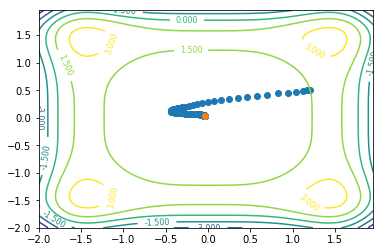

In [34]:
lines_plot(f, xb=-2, xt = 2, yb = -2, yt = 2, delta = 0.05)
path = np.zeros((2,1000))
opt = Momentum(f,df, init=(1.2, 0.5))
for i in range(path.shape[1]):
    path[0, i], path[1,i] = opt.theta
    opt.update(1e-2)
plt.scatter(path[0], path[1])
plt.scatter(path[0, -1:], path[1, -1:])


# Adagrad

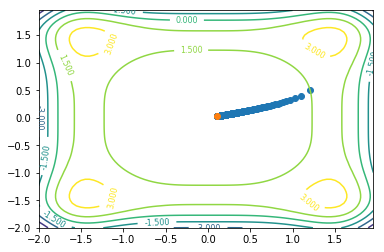

In [35]:
lines_plot(f, xb=-2, xt = 2, yb = -2, yt = 2, delta = 0.05)
path = np.zeros((2,1000))
opt = Adagrad(f,df, init=(1.2, 0.5))
for i in range(path.shape[1]):
    path[0, i], path[1,i] = opt.theta
    opt.update(1e-1)
plt.scatter(path[0], path[1])
plt.scatter(path[0, -1:], path[1, -1:])


# Adadelta

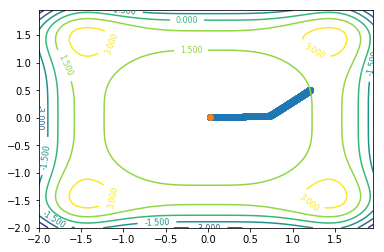

In [36]:
lines_plot(f, xb=-2, xt = 2, yb = -2, yt = 2, delta = 0.05)
path = np.zeros((2,1000))
opt = Adadelta(f,df, init=(1.2, 0.5))
for i in range(path.shape[1]):
    path[0, i], path[1,i] = opt.theta
    opt.update(1e0)
plt.scatter(path[0], path[1])
plt.scatter(path[0, -1:], path[1, -1:])


# Adam

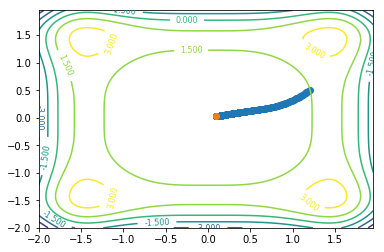

In [37]:
lines_plot(f, xb=-2, xt = 2, yb = -2, yt = 2, delta = 0.05)
path = np.zeros((2,1000))
opt = Adam(f,df, init=(1.2, 0.5))
for i in range(path.shape[1]):
    path[0, i], path[1,i] = opt.theta
    opt.update(1e-2)
plt.scatter(path[0], path[1])
plt.scatter(path[0, -1:], path[1, -1:])


###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [46]:
from torchvision.datasets import MNIST

In [47]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=False, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

In [48]:
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh

In [69]:
def train(network, train_loader, test_loader, epochs, optim, ravel_init=False):
    loss = nn.NLLLoss()
    optimizer = optim
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            network.train()
            for X, y in train_loader:
                X = Variable(X)
                y = Variable(y)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            scheduler.step(loss_batch.data[0])
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []  
            network.eval()
            for X, y in test_loader:
                X = Variable(X)
                y = Variable(y)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [78]:
class linear(nn.Module):
    def __init__(self):
        super(linear, self).__init__()        
        self.linear_layers = nn.Sequential(nn.Linear(784, 200),
                                           nn.ReLU(),
                                           nn.Linear(200, 200),
                                           nn.ReLU(),
                                           nn.Linear(200, 10),
                                           nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [82]:
lin_sgd = linear()
optim_lin_sgd = torch.optim.SGD(lin_sgd.parameters(), lr=0.1)

/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:57: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.018/0.097	Accuracy: 0.999/0.968

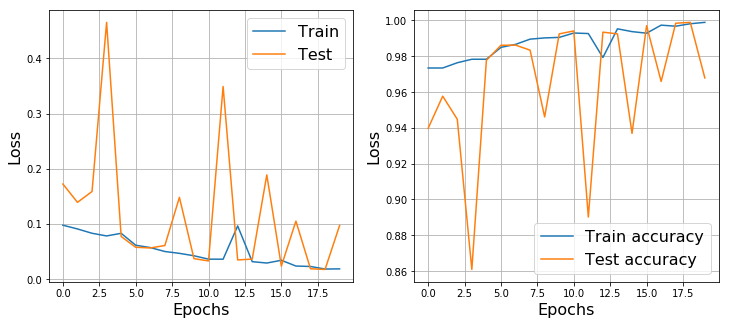

In [83]:
train(lin_sgd, train_loader, test_loader, 20, optim_lin_sgd)

/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:57: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.000/0.000	Accuracy: 1.000/1.000

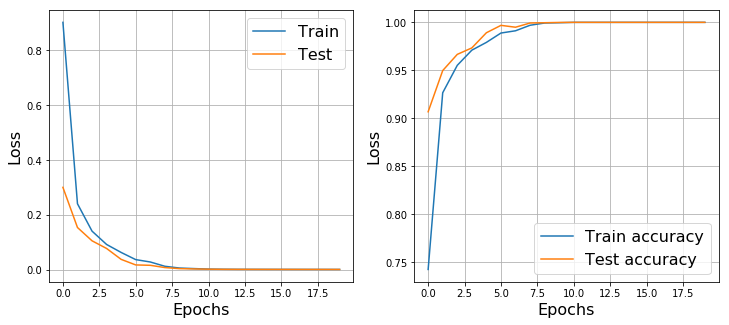

In [84]:
lin_momentum = linear()
optim_lin_momentum = torch.optim.SGD(lin_momentum.parameters(), lr=0.1, momentum=0.9)
train(lin_momentum, train_loader, test_loader, 20, optim_lin_momentum)

/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:57: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.000/0.000	Accuracy: 1.000/1.000

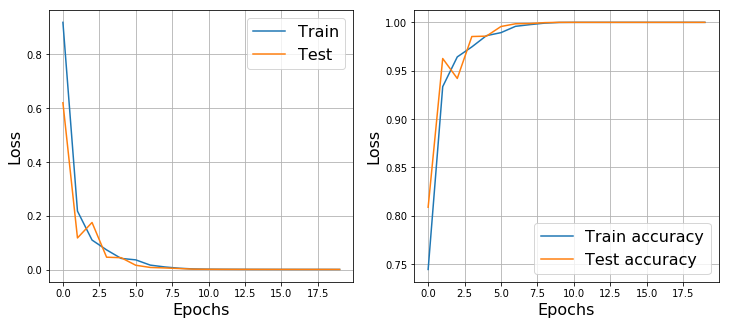

In [88]:
lin_NAG = linear()
optim_lin_NAG = torch.optim.SGD(lin_NAG.parameters(), lr=0.1, momentum=0.9, nesterov=True)
train(lin_NAG, train_loader, test_loader, 20, optim_lin_NAG)

/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:57: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.064/0.075	Accuracy: 0.981/0.975

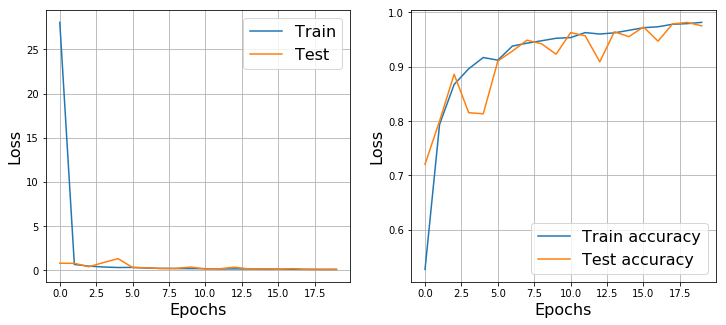

In [94]:
lin_adagrad = linear()
optim_lin_adagrad = torch.optim.Adagrad(lin_adagrad.parameters(), lr=0.1)
train(lin_adagrad, train_loader, test_loader, 20, optim_lin_adagrad)

/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:57: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.122/0.114	Accuracy: 0.964/0.969

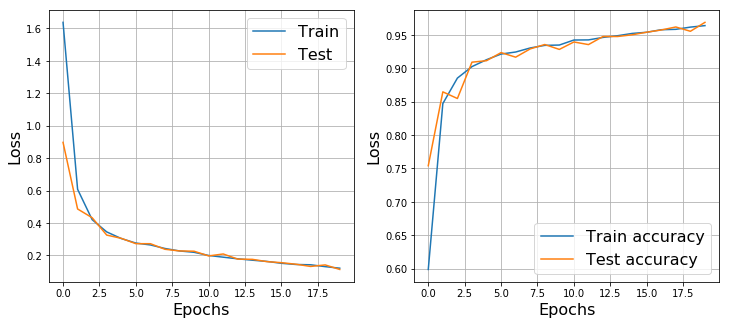

In [90]:
lin_adadelta = linear()
optim_lin_adadelta = torch.optim.Adadelta(lin_adadelta.parameters(), lr=0.1)
train(lin_adadelta, train_loader, test_loader, 20, optim_lin_adadelta)

/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:57: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.032/0.011	Accuracy: 0.991/0.997

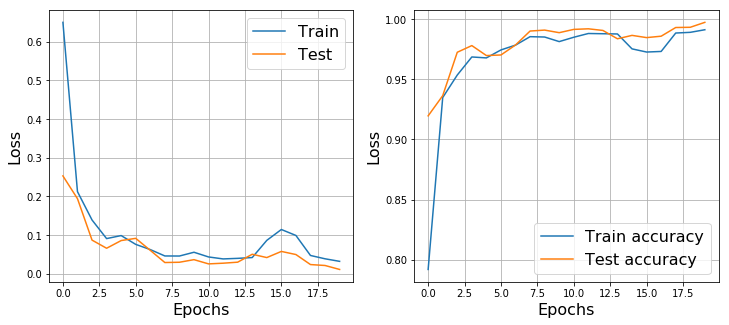

In [92]:
lin_adam  = linear()
optim_lin_adam = torch.optim.Adam(lin_adam.parameters(), lr=0.01)
train(lin_adam, train_loader, test_loader, 20, optim_lin_adam)

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [93]:
class conv(nn.Module):
    def __init__(self):
        super(conv, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 4, 3, padding=1),
                                         nn.MaxPool2d(2),
                                         nn.ReLU(),
                                         
                                         nn.Conv2d(4, 16, 3, padding=1), 
                                         nn.MaxPool2d(2),
                                         nn.ReLU()
                                        )
        
        self.linear_layers = nn.Sequential(nn.Linear(784, 10), 
                                           nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [97]:
conv_sgd = conv()
optim_conv_sgd = torch.optim.SGD(conv_sgd.parameters(), lr=0.1)

/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:57: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.038/0.061	Accuracy: 0.988/0.979

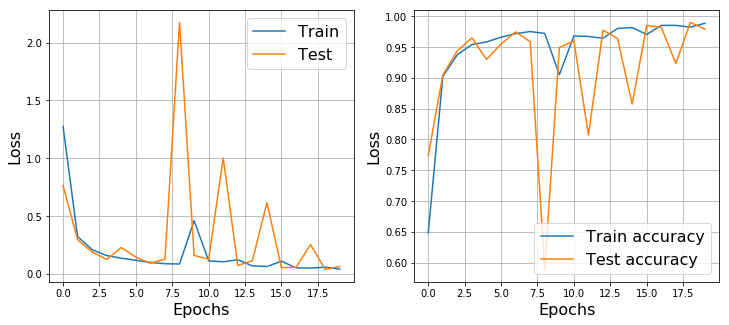

In [98]:
train(conv_sgd, train_loader, test_loader, 20, optim_conv_sgd)

/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:57: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.059/0.072	Accuracy: 0.980/0.975

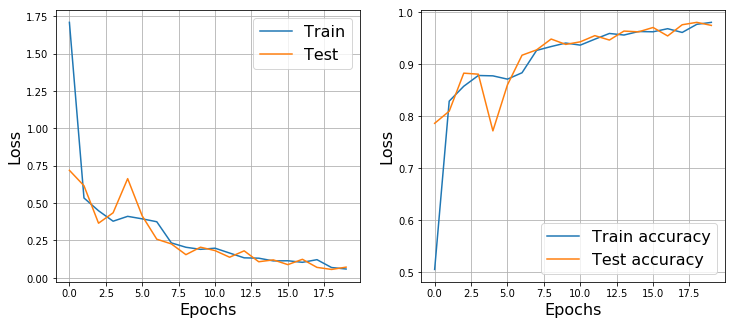

In [99]:
conv_momentum = conv()
optim_conv_momentum = torch.optim.SGD(conv_momentum.parameters(), lr=0.1, momentum=0.9)
train(conv_momentum, train_loader, test_loader, 20, optim_conv_momentum)

/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:57: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.000/0.000	Accuracy: 1.000/1.000

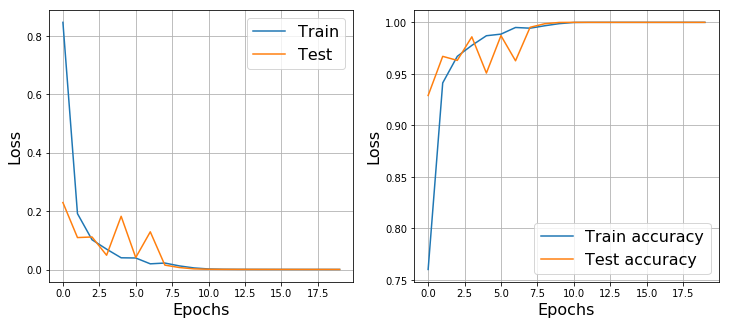

In [100]:
conv_NAG = linear()
optim_conv_NAG = torch.optim.SGD(conv_NAG.parameters(), lr=0.1, momentum=0.9, nesterov=True)
train(conv_NAG, train_loader, test_loader, 20, optim_conv_NAG)

/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:57: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.035/0.031	Accuracy: 0.989/0.991

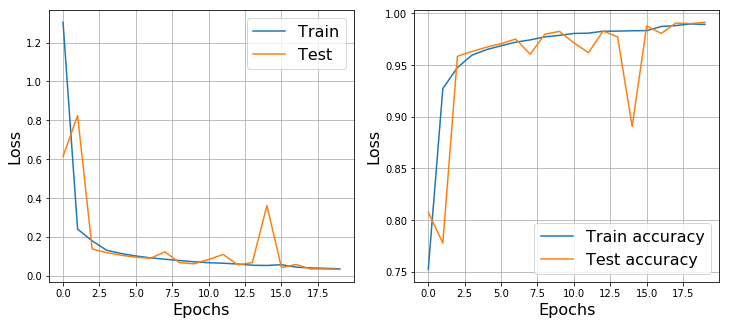

In [102]:
conv_adagrad = conv()
optim_conv_adagrad = torch.optim.Adagrad(conv_adagrad.parameters(), lr=0.1)
train(conv_adagrad, train_loader, test_loader, 20, optim_conv_adagrad)

/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:57: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 12... (Train/Test) NLL: 0.113/0.112	Accuracy: 0.969/0.969Epoch    13: reducing learning rate of group 0 to 1.0000e-02.
Epoch 19... (Train/Test) NLL: 0.112/0.112	Accuracy: 0.969/0.969

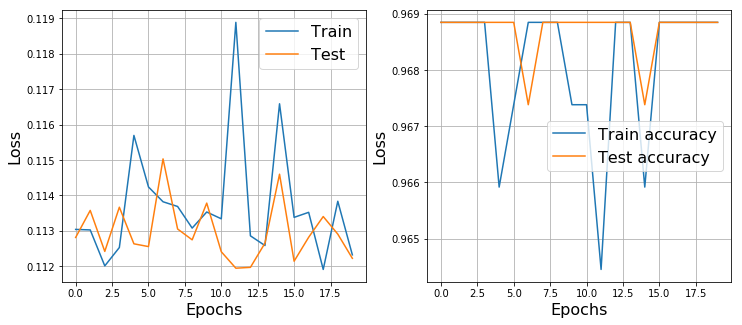

In [103]:
conv_adadelta = conv()
optim_conv_adadelta = torch.optim.Adadelta(conv_adadelta.parameters(), lr=0.1)
train(lin_adadelta, train_loader, test_loader, 20, optim_conv_adadelta)

/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/mi.frolov/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:57: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.001/0.001	Accuracy: 1.000/1.000

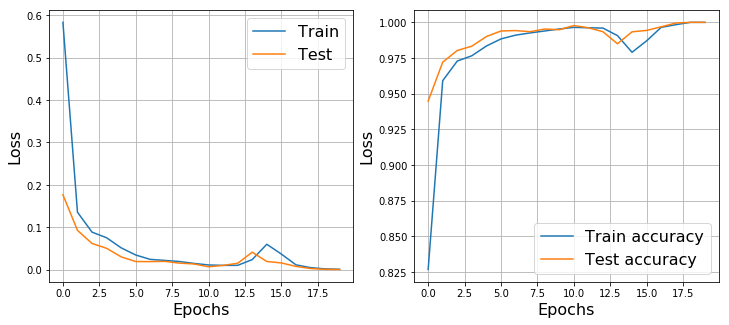

In [104]:
conv_adam  = conv()
optim_conv_adam = torch.optim.Adam(conv_adam.parameters(), lr=0.01)
train(conv_adam, train_loader, test_loader, 20, optim_conv_adam)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: